<a href="https://colab.research.google.com/github/QSBSC/QSBSC_Class_2020/blob/master/Python_code/Scanorama_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Downloading datasets and installing packages

In [0]:
!git clone https://github.com/bobchen1701/SCA_Course_SP_2020.git #downloading datasets from github repository

Cloning into 'SCA_Course_SP_2020'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 12 (delta 1), reused 0 (delta 0), pack-reused 5
Unpacking objects: 100% (12/12), done.


In [0]:
!pip install scanpy #installing scanpy, general use library for organizing and processing count matrices

In [0]:
!pip install scanorama #installing scanorama, Hie et al. 2019 (https://www.nature.com/articles/s41587-019-0113-3)

In [0]:
!pip install leidenalg #installing leiden community detection/clustering algorithm, Traag et al. 2019 (https://www.nature.com/articles/s41598-019-41695-z)

     |████████████████████████████████| 102kB 4.6MB/s 
     |████████████████████████████████| 3.2MB 16.4MB/s 
  Created wheel for leidenalg: filename=leidenalg-0.7.0-cp36-cp36m-linux_x86_64.whl size=1107005 sha256=3d793d038909d74b88b0ae5009c18a0628c29b192d720cb830ed35fed5342283
  Stored in directory: /root/.cache/pip/wheels/29/55/48/5a04693a10f50297bcda23819ca23ab3470a61dd911851c8bd
Successfully built leidenalg


In [0]:
!pip install gprofiler-official #installing gene ontology for functional enrichment discovery, Raudvere et al. 2019 (https://academic.oup.com/nar/article/47/W1/W191/5486750)

## 1. Loading installed python packages and datasets into the environment

In [0]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scanorama
sc.set_figure_params(dpi=80)
sc.settings.verbosity = 3

In [0]:
data_mix = sc.read_h5ad("SCA_Course_SP_2020/50_50_Jurkat_293_Mix.h5ad") #50 50 mix of jurkat and 293 cells
data_jurkat = sc.read_h5ad("SCA_Course_SP_2020/Jurkat.h5ad") #pure jurkat cells
data_293 = sc.read_h5ad("SCA_Course_SP_2020/293.h5ad") #pure 293 cells

data_mix.raw = data_mix
data_jurkat.raw = data_jurkat
data_293.raw = data_293

Each have around 3000 cells and 33,000 genes

In [0]:
data_mix

AnnData object with n_obs × n_vars = 3388 × 32738 
    var: 'gene_ids'

In [0]:
data_jurkat

AnnData object with n_obs × n_vars = 3258 × 32738 
    var: 'gene_ids'

In [0]:
data_293

AnnData object with n_obs × n_vars = 2885 × 32738 
    var: 'gene_ids'

## 2. Normalization, transformation, dimensionality reduction: 
What does this data look like with no batch correction?

In [0]:
#concatenate the 3 anndata objects
combined_data = data_mix.concatenate([data_jurkat,data_293],batch_categories=['50_50','Jurkat','293']) 
combined_data.raw = combined_data

In [0]:
%%time
sc.pp.normalize_total(combined_data) #normalize by median library size, about 14k in this case
combined_data.X = np.arcsinh(combined_data.X) #log1p transform has some unusual effects on the data, so we prefer arcsinh
sc.pp.scale(combined_data) #zscore transform and centering for interpretability
print('Normalization + transformation done')
sc.pp.pca(combined_data) #pca with 50 components
print('PCA done')
sc.pp.neighbors(combined_data) #calculate neighborhood graph with 15 neighbors (default)
print('Neighborhood calculation done')
sc.tl.umap(combined_data) #perform umap using neighborhood graph
print('UMAP done')

normalizing counts per cell
    finished (0:00:00)
Normalization + transformation done
computing PCA with n_comps = 50
    finished (0:01:06)
PCA done
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:09)
Neighborhood calculation done
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:27)
UMAP done
CPU times: user 2min 48s, sys: 2.94 s, total: 2min 51s
Wall time: 1min 48s


In [0]:
combined_data #now we can see the new attributes relating to dimensionality reduction

AnnData object with n_obs × n_vars = 9531 × 32738 
    obs: 'batch'
    var: 'gene_ids'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

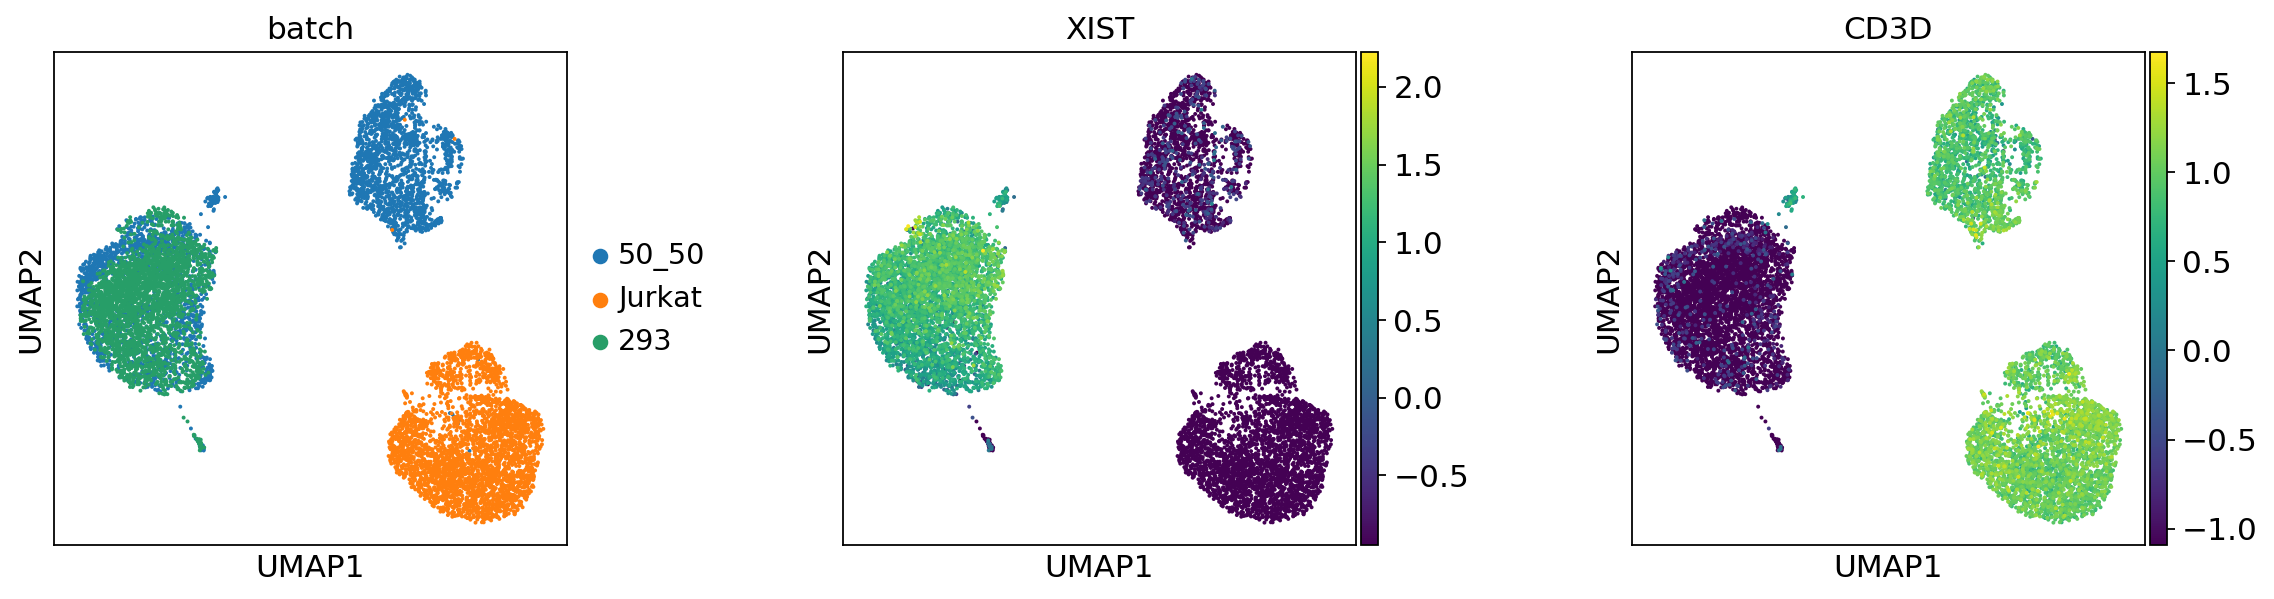

In [0]:
#three things are visualized here
#the known labels (50_50 mix, jurkat, 293), XIST which is enriched in 293 cells, and CD3D which is enriched in Jurkat cells
sc.pl.umap(combined_data,color=['batch','XIST','CD3D'],use_raw=False,return_fig=True,wspace=0.4)

## 3. Integration of low dimensional representations using Scanorama

![Scanorama](https://raw.githubusercontent.com/bobchen1701/SCA_Course_SP_2020/master/Screen%20Shot%202020-03-03%20at%204.52.55%20PM.png)


In [0]:
data_list = [data_mix,data_jurkat,data_293] #put together a list of anndata objects for processing

In [0]:
combined_data.obsm['X_pca_corrected'] = np.concatenate(scanorama.integrate_scanpy(data_list)) 
#integrate the low dimensional representations of these data
#then set the output as an attribute of our original "combined data" anndata object

Found 32738 genes among all datasets
[[0.         0.25567833 0.71230503]
 [0.         0.         0.0150399 ]
 [0.         0.         0.        ]]
Processing datasets (0, 2)
Processing datasets (0, 1)


In [0]:
sc.pp.neighbors(combined_data, use_rep='X_pca_corrected') #calculate neighborhood graph with 15 neighbors (default)
print('Neighborhood calculation done')
sc.tl.umap(combined_data) #perform umap using neighborhood graph (default settings)
print('UMAP done')

computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:04)
Neighborhood calculation done
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:27)
UMAP done


In [0]:
sc.tl.leiden(combined_data,resolution=0.01) 
#run the leiden clustering algorithm using a low resolution parameter, this should produce coarser divisions of communities

running Leiden clustering
    finished: found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


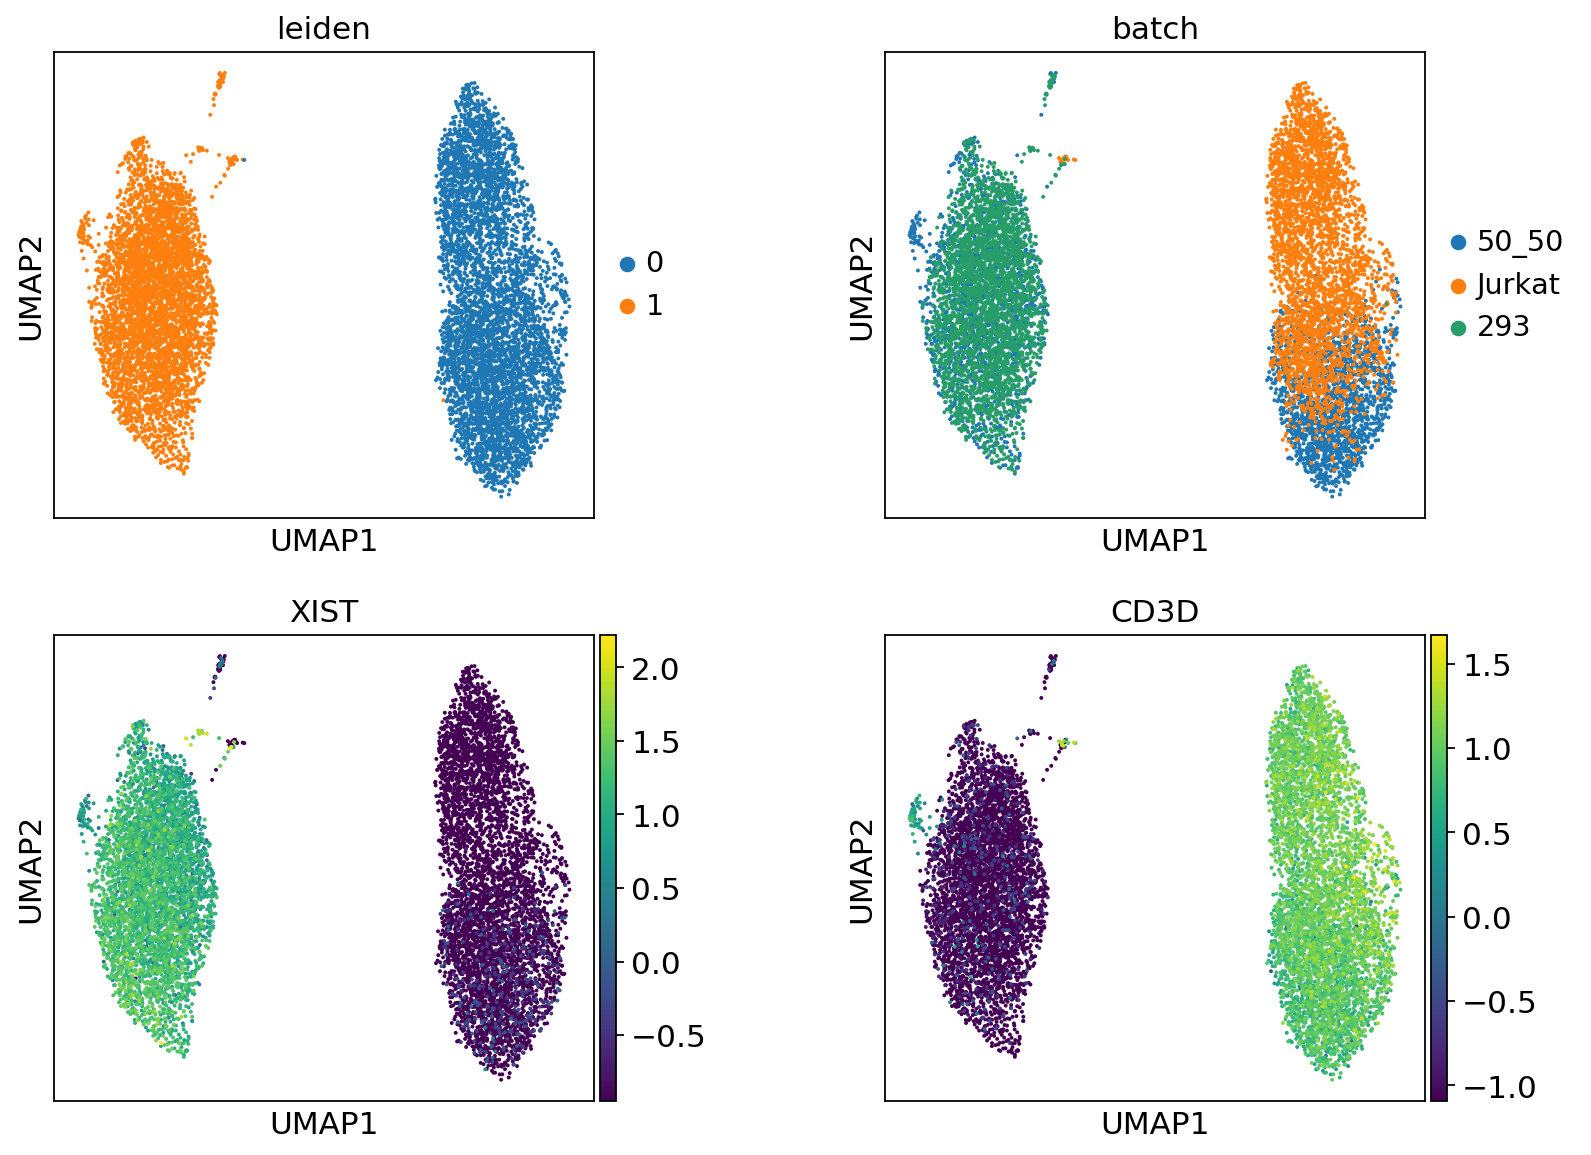

In [0]:
sc.pl.umap(combined_data,color=['leiden','batch','XIST','CD3D'],use_raw=False,return_fig=True,wspace=0.4,ncols=2)
#here we observe that the jurkat and 293 cells have been properly projected to these lower number of dimensions

##4. Differential gene expression analysis, between the observed clusters

Without knowing anything about these clusters of cells intially, how can we determine what their biological function is?

In [0]:
#given the two leiden groups, we can perform a wilcoxon rank sum test to find the most discriminatory genes of each cluster
sc.tl.rank_genes_groups(combined_data,groupby='leiden',method='wilcoxon',n_genes=200) 

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:19)


In [0]:
#here we see that in the .uns annotations, there is now an added 'rank_genes_groups'
combined_data

AnnData object with n_obs × n_vars = 9531 × 32738 
    obs: 'batch', 'leiden'
    var: 'gene_ids'
    uns: 'pca', 'neighbors', 'umap', 'batch_colors', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'X_pca_corrected'
    varm: 'PCs'

In [0]:
combined_data.uns['rank_genes_groups'].keys() #these are sets of information that you can access about the statistical tests

dict_keys(['params', 'scores', 'names', 'logfoldchanges', 'pvals', 'pvals_adj'])

In [0]:
pd.DataFrame(combined_data.uns['rank_genes_groups']['names'])[:10] #visualize the top 10 genes by zscore

,0,1
0,TMSB4X,CKB
1,CD3D,CDKN2A
2,ARHGDIB,XIST
3,EIF5A,CA2
4,ADA,EIF4EBP1
5,OCIAD2,NT5C3B
6,MZB1,CHCHD10
7,BEX1,CBR1
8,NUCB2,GAL
9,AIF1,RAC3


##5. Gene ontology and querying annotation databases

I have a list of discriminative genes per cluster now, what higher level biological processes are they related to?

In [0]:
source_list = ['GO:BP'] #search in the gene ontology, biological process database

In [0]:
GO_Jurkat = sc.queries.enrich(combined_data,group='0',gprofiler_kwargs={'sources':source_list}) #query cluster 0

In [0]:
GO_293 = sc.queries.enrich(combined_data,group='1',gprofiler_kwargs={'sources':source_list}) #query cluster 1 

In [0]:
GO_Jurkat[:10]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:BP,GO:0001775,cell activation,5.431318e-09,True,"""A change in the morphology or behavior of a c...",1455,176,45,17847,0.255682,0.030928,query_1,[GO:0009987]
1,GO:BP,GO:0002684,positive regulation of immune system process,9.027069e-09,True,"""Any process that activates or increases the f...",1189,176,40,17847,0.227273,0.033642,query_1,"[GO:0002376, GO:0002682, GO:0048518]"
2,GO:BP,GO:0045321,leukocyte activation,3.215203e-08,True,"""A change in morphology and behavior of a leuk...",1296,176,41,17847,0.232955,0.031636,query_1,"[GO:0002376, GO:0001775]"
3,GO:BP,GO:0042110,T cell activation,8.331828e-08,True,"""The change in morphology and behavior of a ma...",470,176,24,17847,0.136364,0.051064,query_1,[GO:0046649]
4,GO:BP,GO:0002682,regulation of immune system process,1.587061e-07,True,"""Any process that modulates the frequency, rat...",1671,176,46,17847,0.261364,0.027528,query_1,"[GO:0002376, GO:0050789]"
5,GO:BP,GO:0006955,immune response,6.978542e-07,True,"""Any immune system process that functions in t...",2286,176,54,17847,0.306818,0.023622,query_1,"[GO:0002376, GO:0050896]"
6,GO:BP,GO:0046649,lymphocyte activation,2.035384e-06,True,"""A change in morphology and behavior of a lymp...",744,176,28,17847,0.159091,0.037634,query_1,[GO:0045321]
7,GO:BP,GO:0050852,T cell receptor signaling pathway,2.327970e-06,True,"""A series of molecular signals initiated by th...",198,176,15,17847,0.085227,0.075758,query_1,[GO:0050851]
8,GO:BP,GO:0002429,immune response-activating cell surface recept...,2.834590e-06,True,"""A series of molecular signals initiated by th...",469,176,22,17847,0.125000,0.046908,query_1,"[GO:0002757, GO:0002768]"
9,GO:BP,GO:0050851,antigen receptor-mediated signaling pathway,5.069018e-06,True,"""A series of molecular signals initiated by th...",317,176,18,17847,0.102273,0.056782,query_1,[GO:0002429]


In [0]:
GO_293[:10]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:BP,GO:0006613,cotranslational protein targeting to membrane,0.000146,True,"""The targeting of proteins to a membrane that ...",101,179,10,17847,0.055866,0.099010,query_1,[GO:0006612]
1,GO:BP,GO:0006412,translation,0.000164,True,"""The cellular metabolic process in which a pro...",730,179,25,17847,0.139665,0.034247,query_1,"[GO:0034645, GO:0044267, GO:0010467, GO:0043043]"
2,GO:BP,GO:0006518,peptide metabolic process,0.000168,True,"""The chemical reactions and pathways involving...",895,179,28,17847,0.156425,0.031285,query_1,"[GO:0043603, GO:1901564]"
3,GO:BP,GO:0043043,peptide biosynthetic process,0.000312,True,"""The chemical reactions and pathways resulting...",755,179,25,17847,0.139665,0.033113,query_1,"[GO:1901566, GO:0043604, GO:0006518]"
4,GO:BP,GO:0043604,amide biosynthetic process,0.000637,True,"""The chemical reactions and pathways resulting...",897,179,27,17847,0.150838,0.030100,query_1,"[GO:0044271, GO:0043603]"
5,GO:BP,GO:0006614,SRP-dependent cotranslational protein targetin...,0.001072,True,"""The targeting of proteins to a membrane that ...",96,179,9,17847,0.050279,0.093750,query_1,"[GO:0006613, GO:0045047]"
6,GO:BP,GO:0043603,cellular amide metabolic process,0.001094,True,"""The chemical reactions and pathways involving...",1163,179,31,17847,0.173184,0.026655,query_1,[GO:0034641]
7,GO:BP,GO:0006413,translational initiation,0.001433,True,"""The process preceding formation of the peptid...",196,179,12,17847,0.067039,0.061224,query_1,"[GO:0006412, GO:0044237]"
8,GO:BP,GO:0070972,protein localization to endoplasmic reticulum,0.002550,True,"""A process in which a protein is transported t...",137,179,10,17847,0.055866,0.072993,query_1,[GO:0033365]
9,GO:BP,GO:0045047,protein targeting to ER,0.003154,True,"""The process of directing proteins towards the...",109,179,9,17847,0.050279,0.082569,query_1,"[GO:0006605, GO:0072599]"
